In [2]:
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Last Lab!

## Ensembling and Bias-Variance Tradeoffs

In [3]:
def phi_maker(x, n_basis=24):
    mat = np.ones((x.shape[0], n_basis+1))
    centers = np.linspace(0, 1., n_basis)
    
    for ii in range(1, n_basis+1):
        mat[:, ii] = np.exp(-1./0.02*(x - centers[ii-1])**2)
        
    return mat

In [4]:
def get_preds(alpha=np.exp(0)):
    preds = np.zeros((n_sample, full_x.shape[0]))

    for ii in range(n_sample):
        y = pure_y + np.random.randn(x.shape[0]) * sig
        clf = Ridge(alpha=alpha)
        clf.fit(phi, y)
        preds[ii, :] = clf.predict(full_phi)
        
    return preds

def plotter(preds):
    fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 3))
    ax[0].plot(full_x, preds[:20].T, color='gray', alpha=0.25, linewidth=0.5)
    ax[0].plot(full_x, full_y, linewidth=1.5)
    ax[0].set_title("Sampled Models", fontsize=16)
    
    ax[1].plot(full_x, np.mean(preds, 0), color='gray')
    ax[1].plot(full_x, full_y, linewidth=1.5)
    ax[1].set_title("Mean Prediction", fontsize=16)
    plt.show()

In [13]:
sig = 0.5
n_sample = 1

x = np.linspace(0, 1, 25)
full_x = np.linspace(0, 1, 200)

phi = phi_maker(x)
full_phi = phi_maker(full_x)

pure_y = np.sin(2*np.pi*x)
full_y = np.sin(2*np.pi*full_x)

### Data:

In [28]:
y = pure_y + np.random.randn(x.shape[0])*sig

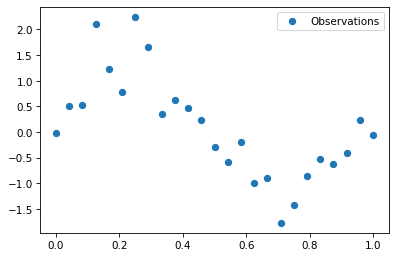

In [29]:
plt.figure(dpi=75)
plt.scatter(x, y, label='Observations')
# plt.plot(full_x, full_y, label='Ground Truth')
plt.legend()
plt.show()

In [50]:
clf = Ridge(alpha=np.exp(-4))
clf.fit(phi, y)
var_preds = clf.predict(full_phi)


clf = Ridge(alpha=np.exp(4))
clf.fit(phi, y)
bias_preds = clf.predict(full_phi)

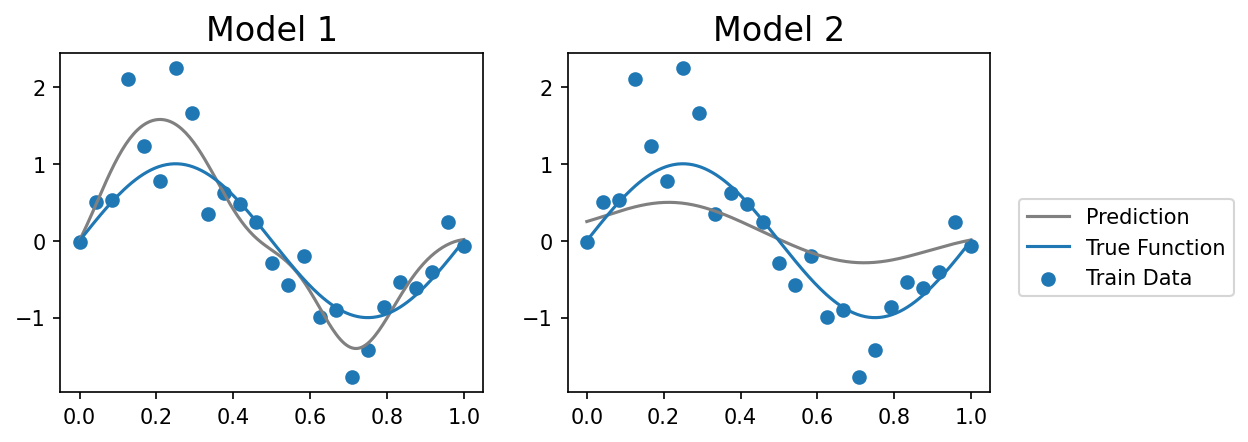

In [51]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(8, 3))
ax[0].plot(full_x, var_preds, color='gray', label="Prediction")
ax[0].plot(full_x, full_y, linewidth=1.5, label='True Function')
ax[0].scatter(x, y, label="Train Data")
ax[0].set_title("Model 1", fontsize=16)

ax[1].plot(full_x, bias_preds, color='gray')
ax[1].plot(full_x, full_y, linewidth=1.5)
ax[1].scatter(x, y, label="Train Data")
ax[1].set_title("Model 2", fontsize=16)
ax[0].legend(bbox_to_anchor=(2.8, 0.6))
plt.savefig("./bias_variance.png", bbox_inches='tight')
plt.show()

## Gaussian Processes

I've built a few helper functions to smooth the process. Using those let's build a gaussian process regression model from scratch

$$
f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))
$$

In [59]:
from scipy.spatial import distance_matrix

#### First we have our kernel function

$$
k(x, x') = \exp(-\frac{1}{2\ell^2} ||x - x'||^2)
$$
$$
k(\tau) = \exp(-\frac{1}{2\ell^2} \tau^2); \quad \tau = ||x - x'||
$$

In [60]:
def kernel(x1, x2, ls=1.):
    dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
    return np.exp( -(1./ls/2) * (dist**2) )

#### And we need some data

$$
f(x) = sin(x) + \frac{1}{2}sin(3x) + \epsilon
$$

or 

$$
f(x) = sin(2x) + 0.6 sin(7x) + \epsilon
$$

In [61]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(3*x) + np.random.randn(x.shape[0])*sig

def data_maker2(x, sig):
    return np.sin(2*x) + 0.6 * np.sin(7*x) + np.random.randn(x.shape[0])*sig

sig = 0.25
train_x = np.linspace(0, 5, 50)
test_x = np.linspace(0, 5, 500)

train_y = data_maker1(train_x, sig=sig)
test_y = data_maker1(test_x, sig=0.)

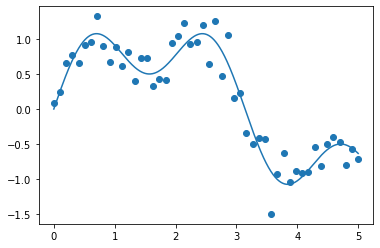

In [62]:
plt.scatter(train_x, train_y)
plt.plot(test_x, test_y)
plt.show()

#### Now we implement the GP

#### Prior:

In [63]:
mean = np.zeros(test_x.shape[0])
cov = kernel(test_x, test_x)

## Pause! Quiz: What is plt.imshow(cov) going to look like?

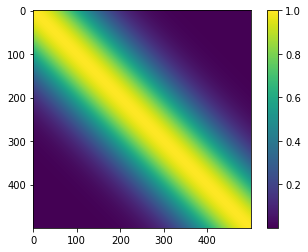

In [66]:
plt.imshow(cov)
plt.colorbar()
plt.show()

In [67]:
prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=20)

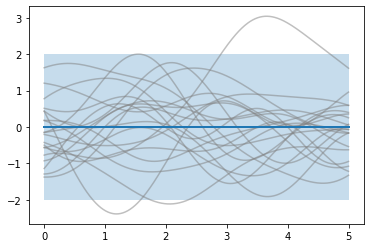

In [68]:
plt.plot(test_x, prior_samples.T, color='gray', alpha=0.5)
plt.plot(test_x, mean, linewidth=2.)
plt.fill_between(test_x, mean - 2*np.diag(cov), mean + 2*np.diag(cov), alpha=0.25)
plt.show()


## Posterior (where things actually start happening)

$$
\bar{f}_{*} = K(x, x_*)^T (K(x, x) + \sigma^2 I)^{-1}y
$$
$$
V(f_{*}) = K(x_*, x_*) - K(x, x_*)^T (K(x, x) + \sigma^2 I)^{-1}K(x, x_*)
$$

## hyperparameters

In [92]:
post_sig_est = 0.5
ell = 0.1

In [93]:
k_x_xstar = kernel(train_x, test_x)
k_x_x = kernel(train_x, train_x)
k_xstar_xstar = kernel(test_x, test_x)

post_mean = k_x_xstar.T @ np.linalg.inv(k_x_x + post_sig_est**2 * np.eye(train_x.shape[0])) @ train_y
post_cov = k_xstar_xstar - k_x_xstar.T @ np.linalg.inv(k_x_x + post_sig_est**2 * np.eye(train_x.shape[0])) @ k_x_xstar

In [94]:
lw_bd = post_mean - np.sqrt(np.diag(post_cov))
up_bd = post_mean + np.sqrt(np.diag(post_cov))

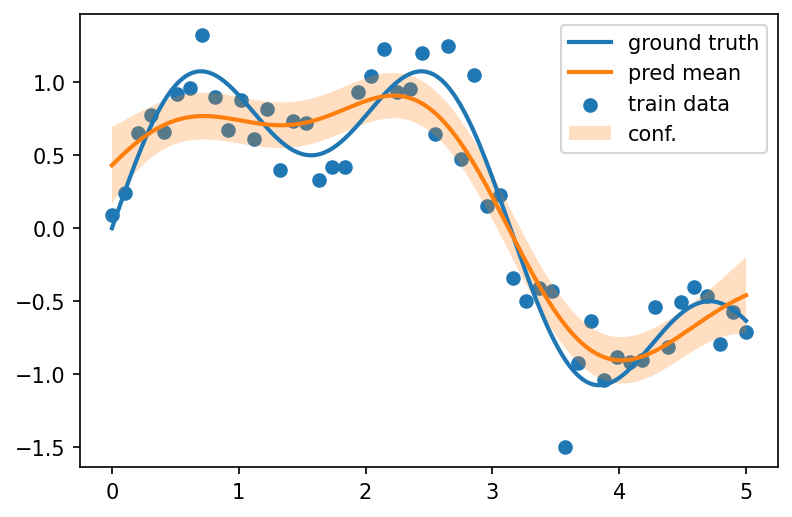

In [95]:
plt.figure(dpi=150)
plt.scatter(train_x, train_y, label='train data')
plt.plot(test_x, test_y, linewidth=2., label='ground truth')
plt.plot(test_x, post_mean, linewidth=2., label='pred mean')
plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25, label='conf.')
plt.legend()
plt.show()


In [ ]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)

In [ ]:
plt.scatter(train_x, train_y)
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.plot(test_x, post_samples.T, color='gray', alpha=0.25)
plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.show()


#### Optimizing the MLL

$$
\log p(y | X) = \log \int p(y | f, X)p(f | X)df
$$
$$
\log p(y | X) = -\frac{1}{2}y^T(K(x, x) + \sigma^2 I)^{-1}y - \frac{1}{2}\log |K(x, x) + \sigma^2 I| - \frac{n}{2}\log 2\pi
$$

In [149]:
def neg_MLL(pars):
    K = kernel(train_x, train_x, ls=pars[0])
    kernel_term = -0.5 * train_y @ np.linalg.inv(K + pars[1]**2 * np.eye(train_x.shape[0])) @ train_y
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1]**2*np.eye(train_x.shape[0])))
    const = -train_x.shape[0]/2. * np.log(2 * np.pi)
    
    return -(kernel_term + logdet + const)

In [150]:
from scipy import optimize

In [151]:
output = optimize.minimize(neg_MLL, x0 = np.array([4,4]), bounds=((0.01, 10.), (0.01, 10.)))

In [152]:
output

      fun: 14.3821903612359
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.03028697e-05,  3.05533377e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 10
     njev: 26
   status: 0
  success: True
        x: array([0.46375075, 0.23083039])